
# WeRateDogs Project

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Gathering">Gathering data</a></li>
<li><a href="#Assessing">Assessing data</a></li>
<li><a href="#Cleaning">Cleaning data</a></li>
</ul>

## Gather  
- Online data (Twitter and Udacity server)
- Stored files(csv file)
    

In [142]:
import pandas as pd
import json
import csv
import re
import tweepy
from tweepy import OAuthHandler
import time
from urllib import request
import matplotlib 

In [143]:
#download image prediction file in url programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
 
def download_txturl(txturl):
    response = request.urlopen(txturl)
    txt = response.read()
    txtstr = str(txt)
    lines = txtstr.split('\\n')
    dest = r'image_predictions.tsv'
    op = open(dest, 'w')
    for line in lines:
        op.write(line + '\n')
    op.close()

download_txturl(url)


In [144]:
consumer_key = 'jbL7N3K4eXgD1zhDfeS2TcnFr'
consumer_secret = 'XeIpJqZ4i8WAolHVCNBqGtILZKY1J0TVJw8GkpW9jDRthls1qn'
access_token = '495295426-3dc2rEDWSI8AX8NxYCpIRV9tk83EwocP7RzbraDC'
access_token_secret = 'zsulnNzoCcHRURBOkfVkb1tLcJPfYinSwfJBpn9Nam1FV'


# search_favorites(consumer_key, consumer_secret, access_token, access_token_secret):
#create authentication for accessing twitter
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

#initialize Tweepy API
api = tweepy.API(auth, wait_on_rate_limit =True, wait_on_rate_limit_notify = True)
tweet_ids = df_archive.tweet_id


In [145]:
count = 0
fails_dict = {}
#save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    
    #loop through each tweet id filtered by the given archive file and write to outfile
    for tweet_id in tweet_ids:
        count += 1        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            
        except tweepy.TweepError as e:
            fails_dict[tweet_id] = e
            pass

Rate limit reached. Sleeping for: 593
Rate limit reached. Sleeping for: 609


In [146]:
df_new = pd.DataFrame(columns=['tweet_id', 'text','retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        text = status['full_text']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df_new = df_new.append(pd.DataFrame([[tweet_id, text, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'text', 'retweet_count', 'favorite_count']))
df_new = df_new.reset_index(drop=True)

In [147]:
df_new.head()
df_new.shape

(2337, 4)

In [148]:
df_archive = pd.read_csv('twitter-archive-enhanced-2.csv')
df_image = pd.read_csv('image-predictions-3.tsv',  delimiter='\t')

## Assess


#### Quality
##### archive table
- Missing data for retweets and likes
- Incorrect ratings data and unnusable values
    - strange values
    - 75 should be 9.75
    - 1776, 420, high values will skew analysis
- Erroneous data types (ID, ratings, favorite_count, retweet_count, timestamp) 
- Retweets and reply-to tweets need to be removed
- Retweets and reply-to columns need to be removed
- Rows without images need to be removed
- Erroneous names
- Source column is hard to understand



##### image prediction table
- results that are not dogs should be removed
- Erroneous datatypes (tweet_id)
- Lowercase given names and surnames

#### Tidiness
##### archive table
- There should be one column for dog stages
- There should be one column for dog breed, and it should be connected to the archive table
- There should be one columns for rating 
- rows with more than one rating should be removed (multiple observations within one row)



## Clean

### Missing data:
- The likes and retweet counts will be added. The archive and new dataframes are combined with an inner join. This will exclude values from the archive that are no longer present. This will be easier if the tweet IDs are strings. 
    

In [149]:
df_new2 = df_new.copy()
df_archive2 = df_archive.copy()
df_image2 = df_image.copy()

In [150]:
df_new2.tweet_id = df_new2['tweet_id'].astype('str')
df_archive2.tweet_id = df_archive2.tweet_id.astype('str')
df_new2.head()

,tweet_id,text,retweet_count,favorite_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,8189,37553
1,892177421306343426,This is Tilly. She's just checking pup on you....,6058,32279
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,4008,24316
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,8345,40902
4,891327558926688256,This is Franklin. He would like you to stop ca...,9038,39096


In [151]:
df_clean = df_archive2.merge(df_new2, how= 'inner', on = 'tweet_id')
df_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,text_y,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,This is Phineas. He's a mystical boy. Only eve...,8189,37553
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,This is Tilly. She's just checking pup on you....,6058,32279
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,This is Archie. He is a rare Norwegian Pouncin...,4008,24316


### Unnecessary columns/data
 - Retweets and rows are removed by removing rows that contain a value in retweet-status and in-reply-to columns and those that do not contain photos. Excess columns are removed

In [152]:
# Rows with other than null values in retweeted and in_reply_to columns are dropped from the dataset
df_clean = df_clean[(df_clean['retweeted_status_id'].isna()) & (df_clean['in_reply_to_status_id'].isna())]

In [153]:
# the old text will be replaced by my newly collected text as it will be used later and I want to be sure of its correctness
df_clean.drop('text_x', axis = 1, inplace = True)

In [154]:
#the name is changed back to 'text'
df_clean.rename(columns = {'text_y': 'text'}, inplace = True)

In [155]:
#tweets without a photo are also dropped
df_clean = df_clean[df_clean.text.str.contains("https://")]

In [156]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,text,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,This is Phineas. He's a mystical boy. Only eve...,8189,37553
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,This is Tilly. She's just checking pup on you....,6058,32279
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,This is Archie. He is a rare Norwegian Pouncin...,4008,24316
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,This is Darla. She commenced a snooze mid meal...,8345,40902
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,This is Franklin. He would like you to stop ca...,9038,39096


In [157]:
#Unnecessary columns are removed.
df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_denominator', 'in_reply_to_status_id', 'in_reply_to_user_id'],  axis =1, inplace = True )

In [158]:
# check for any remaing text columns containing RT. The resulting rows are not retweets.
df_clean[df_clean.text.str.contains('RT ')]

,tweet_id,timestamp,source,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo,text,retweet_count,favorite_count
1268,708400866336894977,2016-03-11 21:15:02 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",https://vine.co/v/iHFqnjKVbIQ,12,None,None,None,None,None,RT if you are as ready for summer as this pup ...,10616,16517
1632,683515932363329536,2016-01-03 05:11:12 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",https://vine.co/v/ibvnzrauFuV,11,None,None,None,None,None,HEY PUP WHAT'S THE PART OF THE HUMAN BODY THAT...,3074,7613
1841,675489971617296384,2015-12-12 01:38:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/675489971...,10,None,None,None,None,None,RT until we find this dog. Clearly a cool dog ...,620,1322
1972,672622327801233409,2015-12-04 03:43:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/672622327...,12,None,None,None,pupper,None,This lil pupper is sad because we haven't foun...,499,1305


### Stage variable tidying
  - re-extract, join, and delete excess columns

In [159]:
#stages are extracted again from the text column
df_clean['stage'] = df_clean.text.str.findall(r'(doggo|floofer|pupper|puppo)')


In [160]:
df_clean.shape

(2090, 14)

In [161]:
# the new stage column is a list. The few columns with double entries are separated with a comma and all values become strings. 
df_clean['stage'] = df_clean['stage'].str.join(',')


In [162]:
#test
df_clean.stage.value_counts()

                        1738
pupper                   229
doggo                     75
puppo                     27
pupper,pupper              7
doggo,pupper               5
floofer                    4
puppo,doggo                2
pupper,doggo               1
pupper,doggo,doggo         1
pupper,pupper,pupper       1
Name: stage, dtype: int64

In [163]:
# A forward slash replaces the comma for visual purposes
df_clean.stage = df_clean.stage.str.replace(',', '/')

In [164]:
#replecated stages are removed
df_clean['stage'].replace('pupper/pupper', 'pupper', inplace =True) 
df_clean['stage'].replace('pupper/doggo/doggo', 'pupper/doggo', inplace = True) 
df_clean['stage'].replace('pupper/pupper/pupper', 'pupper', inplace = True) 

In [165]:
# Excess columns are removed
df_clean2 = df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis =1)

In [166]:
df_clean2.stage.value_counts()

                1738
pupper           237
doggo             75
puppo             27
doggo/pupper       5
floofer            4
pupper/doggo       2
puppo/doggo        2
Name: stage, dtype: int64

### Correction of ratings
  - Re-extract ratings and remove outliers. 

In [167]:
#A regular expression is used to find all ratings
df_clean2['rating'] = df_clean2['text'].str.findall(r'(\d+/10)')
df_clean2.rating.value_counts()

[12/10]                 483
[10/10]                 423
[11/10]                 411
[13/10]                 286
[9/10]                  152
[8/10]                   96
[7/10]                   50
[14/10]                  39
[5/10]                   32
[6/10]                   32
[3/10]                   19
[4/10]                   14
[]                       12
[2/10]                    9
[1/10]                    4
[10/10, 7/10]             3
[11/10, 8/10]             2
[10/10, 4/10]             2
[4/10, 13/10]             1
[75/10]                   1
[420/10]                  1
[10/10, 10/10]            1
[10/10, 7/10, 12/10]      1
[8/10, 11/10]             1
[5/10, 8/10]              1
[0/10]                    1
[10/10, 11/10]            1
[27/10]                   1
[9/10, 2/10]              1
[26/10]                   1
[12/10, 11/10]            1
[11/10, 10/10]            1
[10/10, 6/10]             1
[5/10, 10/10]             1
[10/10, 5/10]             1
[1776/10]           

In [168]:
# rows with multiple ratings or no ratings are removed

df_clean2 = df_clean2[(df_clean2['rating'].str.len() < 2) & (df_clean2['rating'].str.len() > 0)]
df_clean.shape

(2090, 14)

In [169]:
#the value is selected from the list so that it is no more in list format
df_clean2['rating'] = df_clean2['rating'].apply(lambda x: x[0])

In [170]:
df_clean2.head()

,tweet_id,timestamp,source,expanded_urls,rating_numerator,name,text,retweet_count,favorite_count,stage,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,13,Phineas,This is Phineas. He's a mystical boy. Only eve...,8189,37553,,13/10
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,13,Tilly,This is Tilly. She's just checking pup on you....,6058,32279,,13/10
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,12,Archie,This is Archie. He is a rare Norwegian Pouncin...,4008,24316,,12/10
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,13,Darla,This is Darla. She commenced a snooze mid meal...,8345,40902,,13/10
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,12,Franklin,This is Franklin. He would like you to stop ca...,9038,39096,,12/10


In [171]:
# The rating column is split again to extract the numerator 
#df_clean2.rating = df_clean2.rating.str.split('/')

In [172]:
# The numerator is selected
df_clean2.rating = df_clean2['rating'].str.extract('(^\d+)')

In [173]:
df_clean2.rating = df_clean2.rating.astype(float)

In [174]:
# New rating results is compared to the given rating result for exploration of differences. 
df_clean2.query('rating != rating_numerator')

,tweet_id,timestamp,source,expanded_urls,rating_numerator,name,text,retweet_count,favorite_count,stage,rating
1050,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/740373189...,9,None,"After so many requests, this is Bretagne. She ...",13979,36037,,14.0
1147,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/722974582...,4,None,Happy 4/20 from the squad! 13/10 for all https...,1639,4221,,13.0
1184,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/716439118...,50,Bluebert,This is Bluebert. He just saw that both #Final...,219,2438,,11.0
1644,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/682962037...,7,Darrel,This is Darrel. He just robbed a 7/11 and is i...,17572,38227,,10.0
2316,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/666287406...,1,an,This is an Albanian 3 1/2 legged Episcopalian...,63,141,,9.0


In [175]:
#The original rating numerator column is removed
df_clean2.drop('rating_numerator', axis =1, inplace =True)

In [177]:
# Outliers are removed
df_clean2 = df_clean2.query('rating <20')
df_clean2.shape

(2051, 10)

### Breeds should be one column
 - The image prediction data set is cleaned so there is one value per tweet, then added to the main table

In [178]:
#new data frames are created that will designate the most likely dog breed for each tweet. Predictions where no result was a 
#dog breed are removed. 
df_1 = df_image2.query('p1_dog == True')
df_2 = df_image2.query('p1_dog != True & p2_dog == True')
df_3 = df_image2.query('p1_dog != True & p2_dog != True & p3_dog == True')

df_1['breed'] = df_1['p1']
df_2['breed'] = df_2['p2']
df_3['breed'] = df_3['p3']
len(df_1) + len(df_2) + len(df_3)
len(df_image)

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

2075

In [179]:
# The new dataframes are concatenated into one. 
image_clean = pd.concat([df_1, df_2, df_3], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
# All columns except the new breed column and the twitter ID are removed. 
image_clean = image_clean[['tweet_id','breed']]
image_clean.head()

,tweet_id,breed
0,666020888022790149,Welsh_springer_spaniel
1,666029285002620928,redbone
2,666033412701032449,German_shepherd
3,666044226329800704,Rhodesian_ridgeback
4,666049248165822465,miniature_pinscher


In [180]:
# The tweet_id data types are changed to strings so the tables can be merged
image_clean = image_clean.astype(str, copy=True)
# The dataframes are merged so that there is now a breed column in the main dataframe. Tweets with no reasonable prediction will
#now have null values.
df_clean2 = df_clean2.merge(image_clean, how = 'left', on = 'tweet_id')
df_clean2.info()
df_clean2.tweet_id.duplicated().any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 11 columns):
tweet_id          2051 non-null object
timestamp         2051 non-null object
source            2051 non-null object
expanded_urls     2051 non-null object
name              2051 non-null object
text              2051 non-null object
retweet_count     2051 non-null object
favorite_count    2051 non-null object
stage             2051 non-null object
rating            2051 non-null float64
breed             1627 non-null object
dtypes: float64(1), object(10)
memory usage: 192.3+ KB


False

### Name Corrections
 - some of the names were recovered from the text by searching with an additional regular expression. Then erroneous names were corrected one at a time. Then common name errors such as "a" were replaced with "None"

In [228]:
df_clean2.name.value_counts()
df_clean2['names'] = df_clean2['text'].str.extract(r'named (\w+)')

In [229]:
df_clean2['names'].fillna(df_clean2['name']).value_counts()

None        580
a            35
Lucy         11
Cooper       10
Charlie      10
Oliver       10
Tucker        9
Penny         9
Sadie         8
Winston       8
the           8
Lola          8
Toby          7
Daisy         7
Koda          6
Bailey        6
Oscar         6
Jax           6
Bella         6
Stanley       6
Bo            6
Chester       5
Dave          5
Buddy         5
Scout         5
Leo           5
Bentley       5
Louis         5
Rusty         5
an            5
           ... 
Clyde         1
Derby         1
Tedrick       1
Ralph         1
Hero          1
Laela         1
Spencer       1
Suki          1
Timison       1
Rueben        1
Lipton        1
Dietrich      1
Clarkus       1
Ginger        1
Brockly       1
Tilly         1
Kollin        1
Stephan       1
Obi           1
Jeffrie       1
Tino          1
Randall       1
Gin           1
Herb          1
Ike           1
Chompsky      1
Champ         1
Mac           1
Jordy         1
Link          1
Name: names, Length: 959

In [233]:
#Many of the erroneous names have been removed by the other filtering processes above. The ones remaining are "quite" and "a". 
#The dog with the name "a" has an instgram name of "Puffie the Chow". 

df_clean2.loc[df_clean2['tweet_id'] == '881536004380872706', 'name'] = "puffie_the_chow"
df_clean2.loc[df_clean2['tweet_id'] == '765395769549590528', 'name'] = "Zoey"
df_clean2.loc[df_clean2['tweet_id'] == '828650029636317184', 'name'] = "Grace"
df_clean2.loc[df_clean2['name'] == 'a', 'name'] = "None"
df_clean2.loc[df_clean2['name'] == 'an', 'name'] = "None"
df_clean2.loc[df_clean2['name'] == 'quite', 'name'] = "None"
df_clean2.loc[df_clean2['name'] == 'such', 'name'] = "None"
df_clean2.loc[df_clean2['name'] == 'just', 'name'] = "None"
df_clean2.loc[df_clean2['name'] == 'unacceptable', 'name'] = "None"







df_clean2.query('name =="puffie_the_chow"')

,tweet_id,timestamp,source,expanded_urls,name,text,retweet_count,favorite_count,stage,rating,breed,day_of_week,names
51,881536004380872706,2017-06-29,iPhone,https://twitter.com/dog_rates/status/881536004...,puffie_the_chow,Here is a pupper approaching maximum borkdrive...,15425,48000,pupper,14.0,Samoyed,3,NaN


In [226]:
df_clean2.name.value_counts()
df_clean2.to_csv('df_clean2.csv')

### Miscelaneous cleaning 
 - 'source' value simplification, datatype corrections, addition of days of the week column

In [184]:
#source columns are simplified
df_clean2.loc[df_clean2['source'] == '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'source'] = 'iPhone'
df_clean2.loc[df_clean2['source'] == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'source'] = 'twitter_web_client'

In [185]:
df_clean2.source.value_counts()

iPhone                                                                                 1923
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
twitter_web_client                                                                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
Name: source, dtype: int64

In [212]:
#the remaining incorrect datatypes are changed to allow analysis
df_clean2.retweet_count = df_clean2.retweet_count.astype(int)
df_clean2.favorite_count = df_clean2.favorite_count.astype(int)
df_clean2.stage = df_clean2.stage.astype('category')
df_clean2.timestamp = pd.to_datetime(df_clean2['timestamp'])
df_clean2.timestamp = df_clean2.timestamp.values.astype('<M8[W]')
df_clean2.source = df_clean2.source.astype('category')          

In [214]:
# Another column is produced with the day of the week for purposes of analysis
import datetime as dt
df_clean2['day_of_week'] = df_clean2['timestamp'].dt.dayofweek
#df_clean2.day_of_week = df_clean2.day_of_week.astype('category')


# Analyse

In [215]:
import seaborn
df_clean2.describe()

,retweet_count,favorite_count,rating,day_of_week
count,2051.000000,2051.000000,2051.000000,2051.0
mean,2703.915651,8768.528035,10.621160,3.0
std,4719.221862,12668.998290,2.150739,0.0
min,11.000000,76.000000,0.000000,3.0
25%,596.500000,1941.000000,10.000000,3.0
50%,1307.000000,3994.000000,11.000000,3.0
75%,3073.500000,10916.500000,12.000000,3.0
max,82485.000000,162167.000000,14.000000,3.0


In [216]:
df_clean3 = df_clean2.copy()
import statsmodels.api as sm
df_clean3['intercept'] = 1

lm = sm.OLS(df_clean3['rating'], df_clean3[['intercept', 'retweet_count']])

res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     199.8
Date:                Sat, 11 May 2019   Prob (F-statistic):           2.31e-43
Time:                        19:08:52   Log-Likelihood:                -4385.0
No. Observations:                2051   AIC:                             8774.
Df Residuals:                    2049   BIC:                             8785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        10.2538      0.052    196.206      0.000      10.151      10.356
retweet_count     0.0001   9.61e-06     14.136      0.000       0.000       0.000
==============================================================================
Omnibus:                      666.312   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2086.865
Skew:                          -1.648   Prob(JB):                         0.00
Kurtosis:                       6.682   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

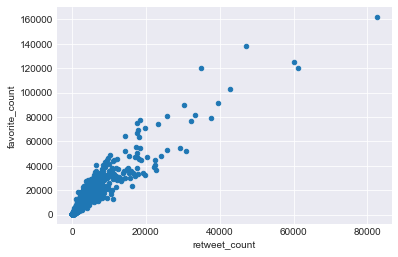

In [217]:
plt.style.use('seaborn-darkgrid')

df_clean2.plot(x = 'retweet_count', y = 'favorite_count', kind = 'scatter')



In [234]:
lm = sm.OLS(df_clean3['favorite_count'], df_clean3[['intercept', 'retweet_count']])

res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 1.252e+04
Date:                Sun, 12 May 2019   Prob (F-statistic):               0.00
Time:                        21:49:57   Log-Likelihood:                -20274.
No. Observations:                2051   AIC:                         4.055e+04
Df Residuals:                    2049   BIC:                         4.056e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2039.6462    120.962     16.862      0.000    1802.424    2276.868
retweet_count     2.4886      0.022    111.876      0.000       2.445       2.532
==============================================================================
Omnibus:                      557.643   Durbin-Watson:                   0.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12508.031
Skew:                           0.735   Prob(JB):                         0.00
Kurtosis:                      15.008   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

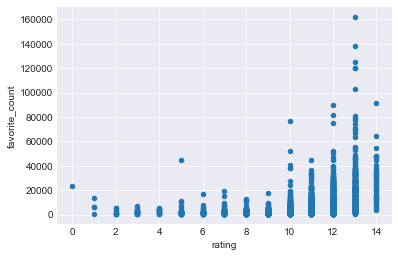

In [219]:
import matplotlib.pyplot as plt


df_clean2.plot(x = 'rating', y = 'favorite_count', kind = 'scatter')


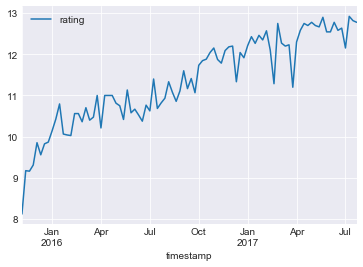

In [222]:

df_time = df_clean2.set_index('timestamp')
#df_clean2.plot(x=df_clean2.favorite_count, y= df_clean2.day_of_week, kind="bar")

#plt.bar(df_time.index, df_time.retweet_count)
#plt.scatter(df_time.index, df_time.rating)
# max 2017-08-01 16:23:56
# min 2017-01-15 21:49:1
#df_clean2.timestamp = df_clean2.timestamp.values.astype('<M8[D]')
#df_clean2.timestamp.hist()
#df_clean.timestamp.sort_values(ascending = True)
dftime2 = df_clean2.groupby('timestamp').mean()[['rating']]
dftime2.plot()


AttributeError: 'NoneType' object has no attribute 'update'

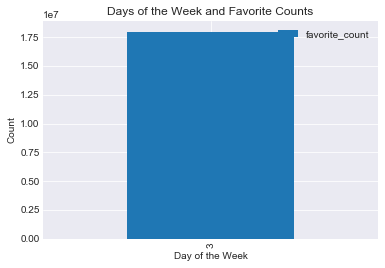

In [223]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df5 = df_clean2.groupby('day_of_week').sum()[['favorite_count']]
df5.plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Day of the Week')
plt.title('Days of the Week and Favorite Counts')

plt.xticks(days)

Text(0.5, 1.0, 'Retweet Counts and Ratings')

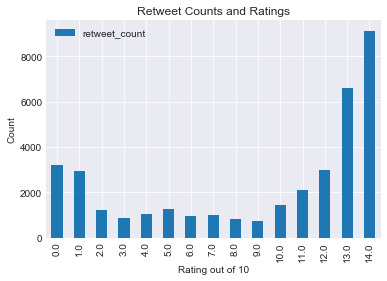

In [196]:
df2 = df_clean2.groupby('rating').mean()[['retweet_count']]
df2.plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Rating out of 10')
plt.title('Retweet Counts and Ratings')

In [438]:
#df4 = df_clean2[df_clean2.stage.str.contains(r'(doggo|floofer|pupper|puppo)')]

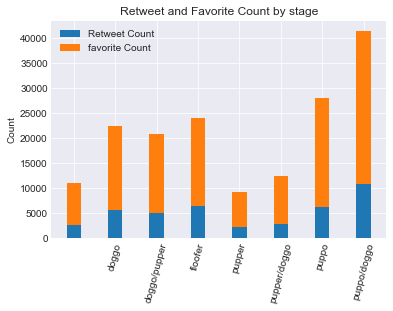

,retweet_count,favorite_count
stage,,
,2549.819087,8394.232436
doggo,5661.162162,16745.216216
doggo/pupper,5101.400000,15689.800000
floofer,6437.500000,17647.750000
pupper,2296.663755,6945.131004
pupper/doggo,2814.500000,9527.500000
puppo,6197.962963,21777.555556


In [201]:
import numpy as np
df4 = df_clean2.groupby('stage').mean()[['retweet_count', 'favorite_count']]


width = 0.35       
p1 = plt.bar(df4.index, df4.retweet_count, width)
p2 = plt.bar(df4.index, df4.favorite_count, width, bottom= df4.retweet_count)

plt.ylabel('Count')
plt.title('Retweet and Favorite Count by stage')
plt.xticks(df4.index, rotation=75)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Retweet Count', 'favorite Count'))

plt.show()

df4.head(7)

In [198]:
breed = df_clean2.groupby( 'breed').count().nlargest(10, 'tweet_id')
breed.reset_index(inplace = True)
df_breed= df_clean2[df_clean2['breed'].isin(breed['breed'])]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

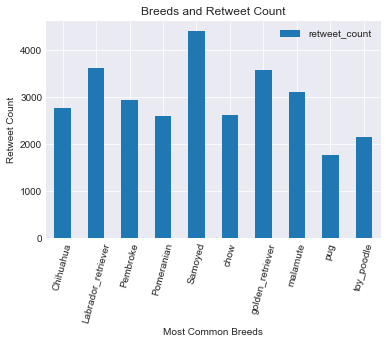

In [225]:
df_breed1 = df_breed.groupby('breed').mean()[['retweet_count']]
df_breed1.plot(kind = 'bar')
plt.xlabel('Most Popular Breeds')
plt.ylabel('Retweet Count')
plt.title('Breeds and Retweet Count')
plt.xticks( rotation=75)

Text(0.5, 1.0, 'Most Common Breeds')

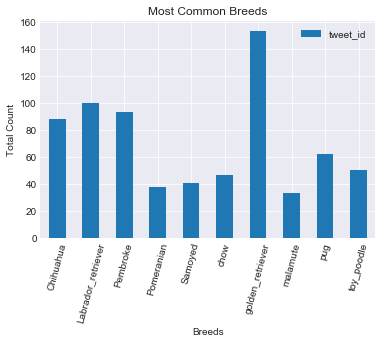

In [235]:
df_breed2 = df_breed.set_index('breed')
df_breed3 = df_breed.groupby('breed').count()[['tweet_id']]
df_breed3.plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.xlabel('Breeds')
plt.ylabel('Total Count')
plt.title('Most Common Breeds')

In [442]:
df_clean2[df_clean2.retweet_count== df_clean2.retweet_count.max()]

,tweet_id,timestamp,source,expanded_urls,name,text,retweet_count,favorite_count,stage,rating,breed,day_of_week
812,744234799360020481,2016-06-18,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/744234799...,None,Here's a doggo realizing you can stand in a po...,82530,162285,doggo,13.0,Labrador_retriever,5


<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [103]:
df_clean2.groupby('rating').sum()

,retweet_count,favorite_count,day_of_week
rating,,,
0.0,3198,23317,4
5.0,9582,44586,5
6.0,3185,16688,5
10.0,21113,88390,15
11.0,106169,487404,63
12.0,527951,2454057,330
13.0,1027975,4150275,448
14.0,181262,686437,73


In [105]:
df_clean2.rating.value_counts()

13.0    157
12.0    119
11.0     27
14.0     25
10.0      5
0.0       1
6.0       1
5.0       1
Name: rating, dtype: int64

In [120]:
df_clean2.shape

(336, 12)